In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading dataset using only columns which are really important
df_meta = pd.read_csv('metadata.csv', usecols=['author_id','pratilipi_id','category_name','reading_time'])
df_user = pd.read_csv('user-interactions.csv', usecols= ['user_id', 'pratilipi_id', 'read_percent'])

In [41]:
df_user.head()

,user_id,pratilipi_id,read_percent
0,5506791963854965,1377786220672965,100.0
3,5506791988747277,1377786224767880,100.0
4,5506791992372558,1377786218111595,100.0
5,5506791984769052,1377786221730720,100.0
6,5506791980825783,1377786227076616,100.0


In [3]:
#considring famous books only since datset is already too large
df_meta = df_meta.loc[df_meta['reading_time']>=1000]

In [4]:
df_meta = df_meta.sort_values(by='reading_time')

In [5]:
df_meta.head()

,author_id,pratilipi_id,category_name,reading_time
516481,-2270332332743399,1377786226671520,moral-inspiring,1000
396105,-2270332334418083,1377786224409031,romance,1000
218775,-2270332345997468,1377786223507765,family,1000
331591,-3428527958586737,1377786220003449,romance,1000
429862,-2270332326956164,1377786226193497,romance,1000


In [83]:
df_meta.category_name.value_counts()

romance                      11148
novels                        5691
suspense                      5048
social                        3170
family                        2740
action-and-adventure          1671
women                         1531
horror                        1367
entertainment                 1101
shortstories                  1082
life                          1035
moral-inspiring                996
webseries                      672
Pratilipi-kalamkar-samman      572
fantasy                        499
comedy                         451
mythology                      441
Pratilipi-Awards-Hindi         439
Indiawale                      389
drama                          343
experiences-and-memories       306
crime                          278
relegion-and-spiritual         271
politics                       205
murder-mystery                 194
translation                    183
swahindi2                      161
science-fiction                158
detective           

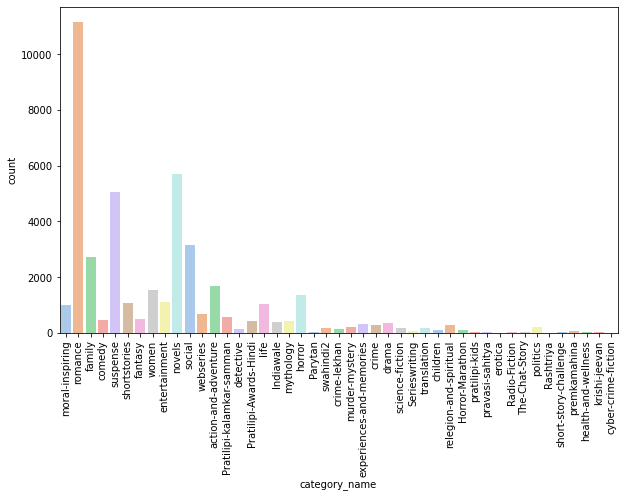

In [91]:
plt.figure(figsize=(10,6))
sns.countplot(x='category_name', data = df_meta, palette='pastel')
plt.xticks(rotation=90)
plt.show()

In [6]:
#considering user only who read the entire book
df_user = df_user.loc[df_user['read_percent']==100.0]

In [7]:
df_user.shape, df_meta.shape

((8702791, 3), (43020, 4))

In [8]:
#merging both the dataset
df = df_meta.merge(df_user, on='pratilipi_id', how = 'inner')
df.shape

(1229343, 6)

In [65]:
#since most of pratilipies have different categories at different row that's why grouping them and joining the categories
#this is for content based recommendations in our use case category_name based recommendations
temp = df.groupby('pratilipi_id').agg({'category_name': lambda x: ' '.join(set(x))}).reset_index()
temp.head(10)

,pratilipi_id,category_name
0,-868854658328888,suspense
1,-862730317031736,social
2,-844691134572856,shortstories suspense horror
3,-843753303402808,social romance
4,-821302225365304,romance social
5,-805561288190264,social
6,-793460789831992,romance
7,-774778583869752,social
8,-731837801261368,romance
9,-727142821095736,shortstories romance moral-inspiring


In [66]:
# creating another dataframe for collabrative filtering recommendations here we are considering users 
temp2 = df.groupby(['pratilipi_id', 'user_id', 'author_id']).agg({'category_name': lambda x: ' '.join(set(x))}).reset_index()
temp2.head(10)

,pratilipi_id,user_id,author_id,category_name
0,-868854658328888,5506791955529201,-2882685197546865,suspense
1,-868854658328888,5506791993547868,-2882685197546865,suspense
2,-868854658328888,5506791995219032,-2882685197546865,suspense
3,-868854658328888,5506791995230274,-2882685197546865,suspense
4,-868854658328888,5506791995256459,-2882685197546865,suspense
5,-868854658328888,5506791995295105,-2882685197546865,suspense
6,-868854658328888,5506791995316845,-2882685197546865,suspense
7,-868854658328888,5506791995320587,-2882685197546865,suspense
8,-868854658328888,5506791995322336,-2882685197546865,suspense
9,-868854658328888,5506791995354618,-2882685197546865,suspense


In [67]:
#choosing first 100k rows
tm_df = temp.loc[:100000]

In [80]:
tm_df.sample()

,pratilipi_id,category_name
11940,1377786228056119,Indiawale romance suspense


In [68]:
#count vectorerizer to create vector
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=50,stop_words='english')

In [69]:
vector = cv.fit_transform(tm_df['category_name']).toarray()

In [70]:
vector[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0], dtype=int64)

In [71]:
# cosine similarity to get similarity between vectors
from sklearn.metrics.pairwise import cosine_similarity

In [72]:
similarity = cosine_similarity(vector)

In [73]:
similarity[0]

array([1.        , 0.        , 0.57735027, ..., 0.        , 0.        ,
       0.        ])

In [77]:
#function to recoomend based on books a user watch category_based filtering 
def recommend(book_id):
    tem_lst = []
    index = tm_df[tm_df['pratilipi_id'] == book_id].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        tem_lst.append(tm_df.iloc[i[0]].pratilipi_id)
    return tem_lst

In [81]:
rec_lst = recommend(1377786228056119)
print(rec_lst)

[1377786224559030, 1377786224824649, 1377786225003004, 1377786225526545, 1377786225607351]


In [82]:
#recommended pratilipies dataframe for better understanding 
tm_df[tm_df['pratilipi_id'].isin(rec_lst)]

,pratilipi_id,category_name
8185,1377786224559030,Indiawale suspense romance
8484,1377786224824649,Indiawale romance suspense
8676,1377786225003004,Indiawale romance suspense
9310,1377786225526545,Indiawale suspense romance
9421,1377786225607351,Indiawale suspense romance


In [22]:
#considering 100k rows since the dataset is too large to computer similarity
tm_df2 = temp2.loc[:30000]

In [23]:
vector2 = cv.fit_transform(tm_df2['category_name']).toarray()

In [24]:
similarity = cosine_similarity(vector2)

In [25]:
similarity.shape

(30001, 30001)

In [26]:
#function to recommend pratilipies based on similar users read pratilipies.   
def recommend2(user_id):
    usr_lst= []
    book_lst = set()
    index = tm_df2[tm_df2['user_id'] == user_id].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:]:
        if len(book_lst) < 5:
            sim_users = tm_df2.iloc[i[0]].user_id
            usr_lst.append(sim_users)
            for j in usr_lst:
                k = tm_df2[tm_df2['user_id']==j]['pratilipi_id'].values[0]
                book_lst.add(k)
    return list(book_lst)
#     print(usr_lst)

In [38]:
tm_df2.sample()

,pratilipi_id,user_id,author_id,category_name
18912,1377786216331554,5506791964756353,-2270332348764612,The-Chat-Story Parytan romance


In [39]:
rec_lst2 = recommend2(5506791964756353)
print(rec_lst2)

[1377786216331554, 1114522134943432, 979877554722504, 1377786215757175, 1377786216312666]


In [40]:
tm_df2[tm_df2['pratilipi_id'].isin(rec_lst2)]

,pratilipi_id,user_id,author_id,category_name
6639,979877554722504,3280684228977316,-3678460257170801,social romance
6640,979877554722504,3332846191551140,-3678460257170801,social romance
6641,979877554722504,3453645753852580,-3678460257170801,social romance
6642,979877554722504,3523322783376036,-3678460257170801,social romance
6643,979877554722504,3595524319388324,-3678460257170801,social romance
...,...,...,...,...
19256,1377786216331554,5506791996446109,-2270332348764612,The-Chat-Story Parytan romance
19257,1377786216331554,5506791996452498,-2270332348764612,The-Chat-Story Parytan romance
19258,1377786216331554,5506791996488561,-2270332348764612,The-Chat-Story Parytan romance
19259,1377786216331554,5506791996530857,-2270332348764612,The-Chat-Story Parytan romance
